In [1]:
!python -m venv /path/to/new/virtual/env_quant_finance


In [1]:
!pip3 install tensorflow

  Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp311-cp311-win_amd64.whl (375.9 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\diego\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\client_channel\\lb_policy\\grpclb\\client_load_reporting_filter.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\diego\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
!pip3 install arch 

   ---------------------------------------- 0.0/927.1 kB ? eta -:--:--
   ---------------------------------------- 10.2/927.1 kB ? eta -:--:--
   - ------------------------------------- 41.0/927.1 kB 653.6 kB/s eta 0:00:02
   ------------------ --------------------- 419.8/927.1 kB 4.4 MB/s eta 0:00:01
   ---------------------------------------- 927.1/927.1 kB 7.3 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\diego\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [18]:
!pip3 install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ------------ --------------------------- 92.2/294.9 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\diego\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# =========================
# Imports & Config
# =========================
import os
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta

from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, balanced_accuracy_score,
                             brier_score_loss)
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (11, 5)

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from arch import arch_model

SEED = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
np.random.seed(SEED)
torch.manual_seed(SEED)


In [20]:
# -------------------------
# User-configurable params
# -------------------------
TICKER = "NVDA"
START = "2010-01-01"     # start of history
END = None               # None = today
LABEL_MODE = "oc"        # "oc" = predict next day's Open->Close direction; "cc_adj" = predict Adj Close_{t+1} vs Adj Close_{t}
TEST_YEARS = 3           # last N years = test
TC_BPS = 10              # transaction cost per side in bps
UPPER = 0.55             # go long if p_up >= UPPER
LOWER = 0.45             # go short if p_up <= LOWER, else flat
SEQ_LEN = 60             # LSTM sequence length (days)
EPOCHS = 150
BATCH_SIZE = 128
VERBOSE = 1

## Data download

In [ ]:
# =========================
# Data Download
# =========================
def load_data(ticker=TICKER, start=START, end=END):
    df = yf.download(ticker, start=start, end=end, auto_adjust=True, progress=False)
    # Keep required columns; yfinance has 'Adj Close'
    df = df[['Open','High','Low','Close','Volume']].dropna()
    df.index = pd.to_datetime(df.index)
    
    if isinstance(df.columns, pd.MultiIndex):
        # Drop the first level (“Ticker”) and keep only the actual field names
        df = df.xs(TICKER, axis=1, level=1)        # (n_rows × 6) DataFrame

    df = df.ffill()
    return df

df = load_data()

## Feature engineering

In [22]:
# =========================
# 2) Feature Engineering
# =========================
def add_indicators(df):
    out = df.copy()

    # Returns (Adj Close to handle corporate actions for multi-day features)
    out["ret1"] = out["Close"].pct_change()
    out["logret1"] = np.log1p(out["ret1"])
    out["ret5"]  = out["Close"].pct_change(5)
    out["ret10"] = out["Close"].pct_change(10)
    out["ret10"] = out["Close"].pct_change(10)
    out["ret21"] = out["Close"].pct_change(21)

    # Rolling volatility (realized)
    out["vol21"] = out["logret1"].rolling(21).std() * np.sqrt(252)
    out["vol63"] = out["logret1"].rolling(63).std() * np.sqrt(252)

    # Momentum/oscillators
    out["rsi14"] = RSIIndicator(close=out["Close"], window=14).rsi()
    stoch = StochasticOscillator(high=out["High"], low=out["Low"], close=out["Close"], window=14, smooth_window=3)
    out["stoch_k"] = stoch.stoch()
    out["stoch_d"] = stoch.stoch_signal()   

    macd = MACD(close=out["Close"], window_slow=26, window_fast=12, window_sign=9)
    out["macd"] = macd.macd()
    out["macd_sig"] = macd.macd_signal()
    out["macd_diff"] = macd.macd_diff()

    # Trend / MAs
    for w in [10, 20, 50, 200]:
        out[f"sma{w}"] = SMAIndicator(close=out["Close"], window=w).sma_indicator()
    out["ema20"] = EMAIndicator(close=out["Close"], window=20).ema_indicator()
    out["price_sma20"] = out["Close"] / out["sma20"]
    out["price_sma50"] = out["Close"] / out["sma50"]
    out["price_sma200"] = out["Close"] / out["sma200"]

    # Bollinger
    bb = BollingerBands(close=out["Close"], window=20, window_dev=2)
    out["bb_b"] = bb.bollinger_pband()    # %b
    out["bb_w"] = bb.bollinger_wband()    # bandwidth

    # Volatility/Range
    out["atr14"] = AverageTrueRange(high=out["High"], low=out["Low"], close=out["Close"], window=14).average_true_range()

    # Volume / OBV
    out["obv"] = OnBalanceVolumeIndicator(close=out["Close"], volume=out["Volume"]).on_balance_volume()
    out["vol_z20"] = (out["Volume"] - out["Volume"].rolling(20).mean()) / out["Volume"].rolling(20).std()

    # Lags of daily returns to inject short-term dynamics
    for lag in [1, 2, 5]:
        out[f"logret1_lag{lag}"] = out["logret1"].shift(lag)

    # Clean
    out = out.dropna().copy()
    return out

df_feat = add_indicators(df)

C:\Users\diego\AppData\Local\Temp\ipykernel_67956\1268902520.py:126: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



AttributeError: 'tuple' object has no attribute 'show'

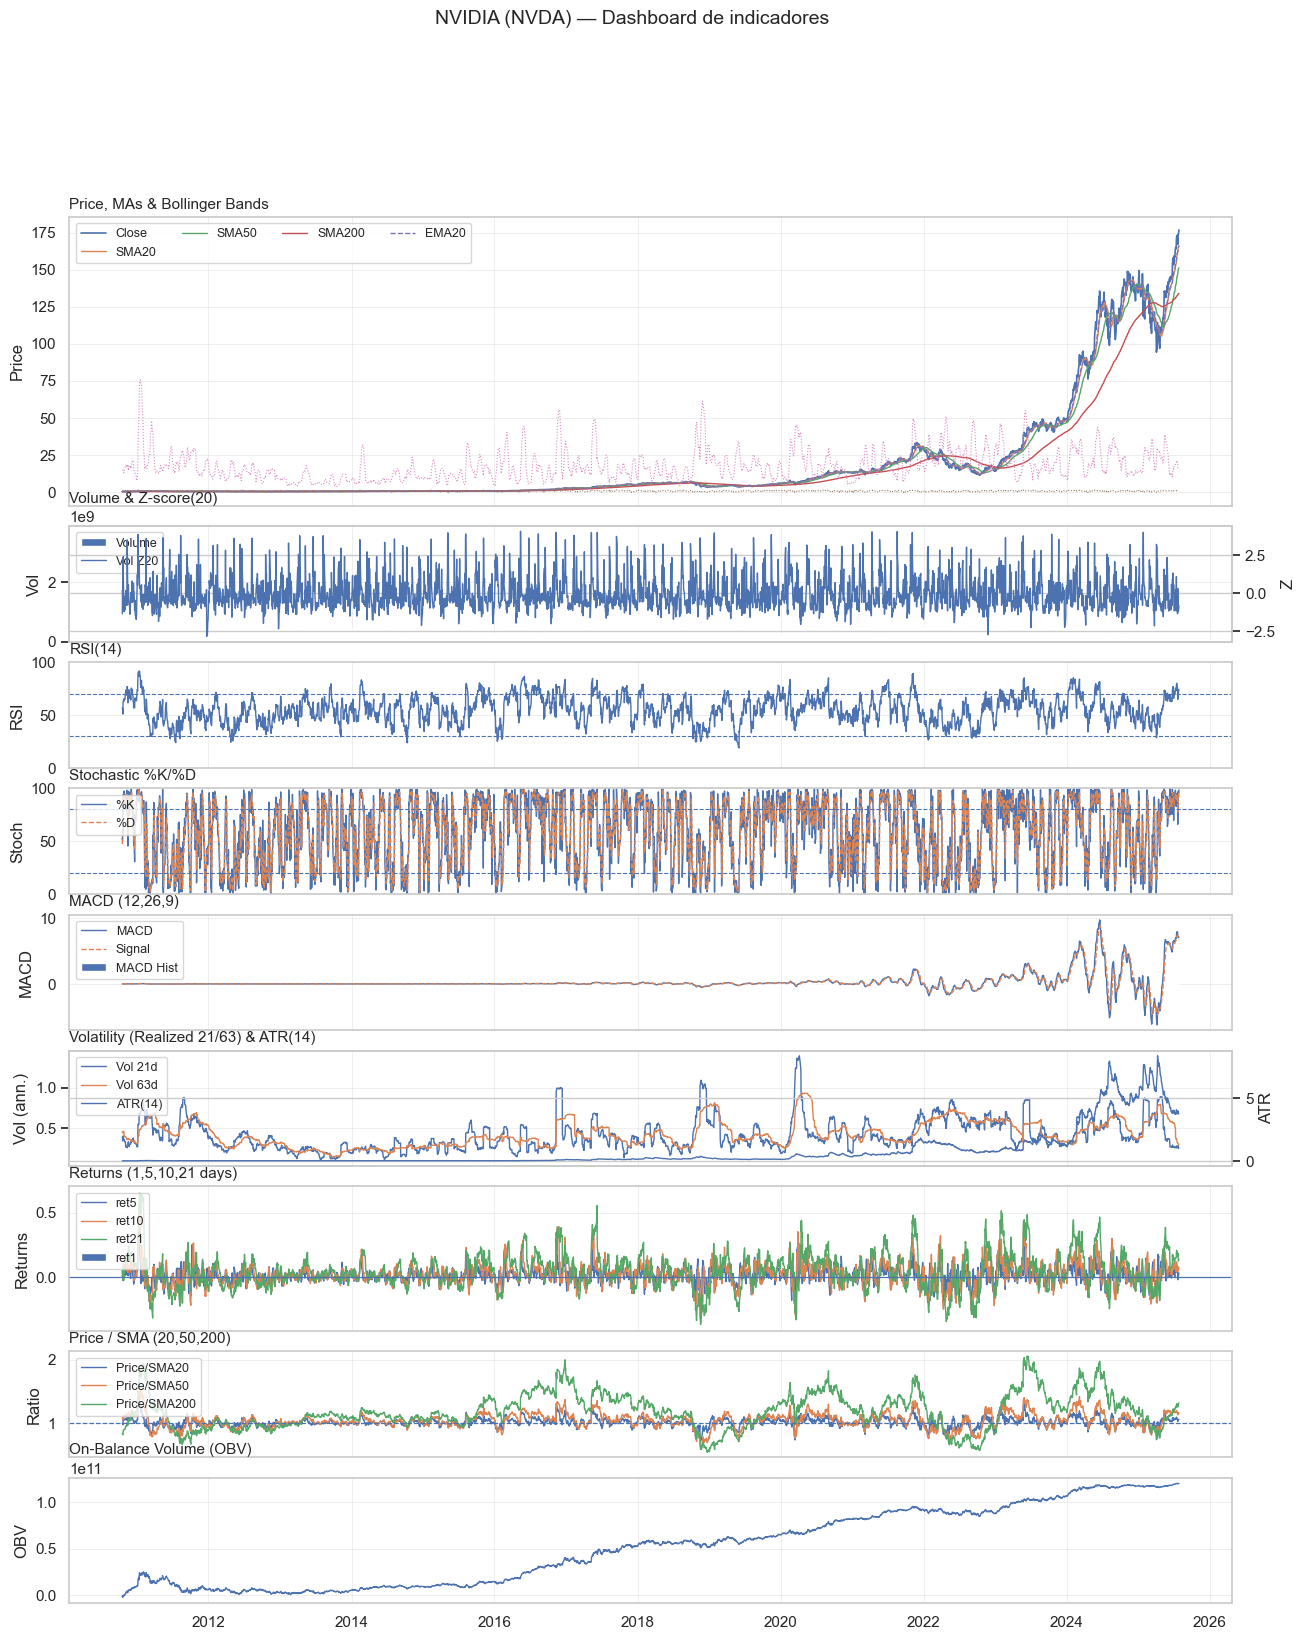

In [ ]:
import matplotlib.dates as mdates

# --------------------------
# Dashboard 
# --------------------------
def make_dashboard(df_feat: pd.DataFrame, title: str = "NVDA — Technical Indicators"):
    # Seaborn theme
    sns.set_theme(style="whitegrid")

    # Grid with shared x-axis
    heights = [3.0, 1.2, 1.1, 1.1, 1.2, 1.2, 1.5, 1.1, 1.3]
    fig, axs = plt.subplots(
        nrows=9, ncols=1, figsize=(15, 18), sharex=True,
        gridspec_kw={"height_ratios": heights, "hspace": 0.15}
    )
    idx = df_feat.index

    # Date formatter (concise)
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)

    # 1) Price + MAs + Bollinger
    ax = axs[0]
    ax.plot(idx, df_feat["Close"], label="Close", linewidth=1.2)
    for ma in [20, 50, 200]:
        ax.plot(idx, df_feat[f"sma{ma}"], label=f"SMA{ma}", linewidth=1.0)
    ax.plot(idx, df_feat["ema20"], label="EMA20", linewidth=1.0, linestyle="--")

    #ax.fill_between(idx, df_feat["bb_low"], df_feat["bb_high"], alpha=0.15, label="Bollinger 20,2")
    ax.plot(idx, df_feat["bb_b"], linewidth=0.8, linestyle=":")
    ax.plot(idx, df_feat["bb_w"], linewidth=0.8, linestyle=":")
    
    ax.set_title("Price, MAs & Bollinger Bands", loc="left", fontsize=11)
    ax.set_ylabel("Price")
    ax.legend(ncols=4, fontsize=9)

    # 2) Volume + z-score (secondary axis)
    ax = axs[1]
    ax.bar(idx, df_feat["Volume"], label="Volume", width=1.0)
    ax2 = ax.twinx()
    ax2.plot(idx, df_feat["vol_z20"], label="Vol Z20", linewidth=1.0)
    ax.set_title("Volume & Z-score(20)", loc="left", fontsize=11)
    ax.set_ylabel("Vol")
    ax2.set_ylabel("Z")
    # Simple legends
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, fontsize=9, loc="upper left")

    # 3) RSI(14)
    ax = axs[2]
    ax.plot(idx, df_feat["rsi14"], linewidth=1.0)
    ax.axhline(70, linestyle="--", linewidth=0.8)
    ax.axhline(30, linestyle="--", linewidth=0.8)
    ax.set_ylim(0, 100)
    ax.set_title("RSI(14)", loc="left", fontsize=11)
    ax.set_ylabel("RSI")

    # 4) Stochastic
    ax = axs[3]
    ax.plot(idx, df_feat["stoch_k"], label="%K", linewidth=1.0)
    ax.plot(idx, df_feat["stoch_d"], label="%D", linewidth=1.0, linestyle="--")
    ax.axhline(80, linestyle="--", linewidth=0.8)
    ax.axhline(20, linestyle="--", linewidth=0.8)
    ax.set_ylim(0, 100)
    ax.set_title("Stochastic %K/%D", loc="left", fontsize=11)
    ax.set_ylabel("Stoch")
    ax.legend(fontsize=9, loc="upper left")

    # 5) MACD (hist + lines)
    ax = axs[4]
    ax.bar(idx, df_feat["macd_diff"], label="MACD Hist", width=1.0)
    ax.plot(idx, df_feat["macd"], label="MACD", linewidth=1.0)
    ax.plot(idx, df_feat["macd_sig"], label="Signal", linewidth=1.0, linestyle="--")
    ax.set_title("MACD (12,26,9)", loc="left", fontsize=11)
    ax.set_ylabel("MACD")
    ax.legend(fontsize=9, loc="upper left")

    # 6) Volatility realized + ATR (secondary)
    ax = axs[5]
    ax.plot(idx, df_feat["vol21"], label="Vol 21d", linewidth=1.0)
    ax.plot(idx, df_feat["vol63"], label="Vol 63d", linewidth=1.0)
    ax2 = ax.twinx()
    ax2.plot(idx, df_feat["atr14"], label="ATR(14)", linewidth=1.0)
    ax.set_title("Volatility (Realized 21/63) & ATR(14)", loc="left", fontsize=11)
    ax.set_ylabel("Vol (ann.)")
    ax2.set_ylabel("ATR")
    h1, l1 = ax.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax.legend(h1 + h2, l1 + l2, fontsize=9, loc="upper left")

    # 7) Returns (daily bar + multi-day lines)
    ax = axs[6]
    ax.bar(idx, df_feat["ret1"], label="ret1", width=1.0)
    ax.plot(idx, df_feat["ret5"], label="ret5", linewidth=1.0)
    ax.plot(idx, df_feat["ret10"], label="ret10", linewidth=1.0)
    ax.plot(idx, df_feat["ret21"], label="ret21", linewidth=1.0)
    ax.axhline(0, linewidth=0.9)
    ax.set_title("Returns (1,5,10,21 days)", loc="left", fontsize=11)
    ax.set_ylabel("Returns")
    ax.legend(fontsize=9, loc="upper left")

    # 8) Price/SMA ratios
    ax = axs[7]
    ax.plot(idx, df_feat["price_sma20"], label="Price/SMA20", linewidth=1.0)
    ax.plot(idx, df_feat["price_sma50"], label="Price/SMA50", linewidth=1.0)
    ax.plot(idx, df_feat["price_sma200"], label="Price/SMA200", linewidth=1.0)
    ax.axhline(1.0, linestyle="--", linewidth=0.9)
    ax.set_title("Price / SMA (20,50,200)", loc="left", fontsize=11)
    ax.set_ylabel("Ratio")
    ax.legend(fontsize=9, loc="upper left")

    # 9) OBV
    ax = axs[8]
    ax.plot(idx, df_feat["obv"], linewidth=1.0)
    ax.set_title("On-Balance Volume (OBV)", loc="left", fontsize=11)
    ax.set_ylabel("OBV")

    # X-axis formatting
    axs[-1].xaxis.set_major_locator(locator)
    axs[-1].xaxis.set_major_formatter(formatter)
    for ax in axs:
        ax.grid(True, which="major", linewidth=0.4, alpha=0.6)

    fig.suptitle(title, fontsize=14, y=0.995)
    fig.tight_layout(rect=[0, 0.01, 1, 0.98])
    return fig, axs

# =========================
# 3) Uso
# =========================

fig = make_dashboard(df_feat, title="NVIDIA (NVDA) — Dashboard de indicadores")
fig.show()

## GARCH vs GJR GARCH

Best GARCH(p,q): (p,q)=(1,1)  BIC=17284.48
Best GJR-GARCH(p,o,q): (p,o,q)=(1,1,1)  BIC=17258.22


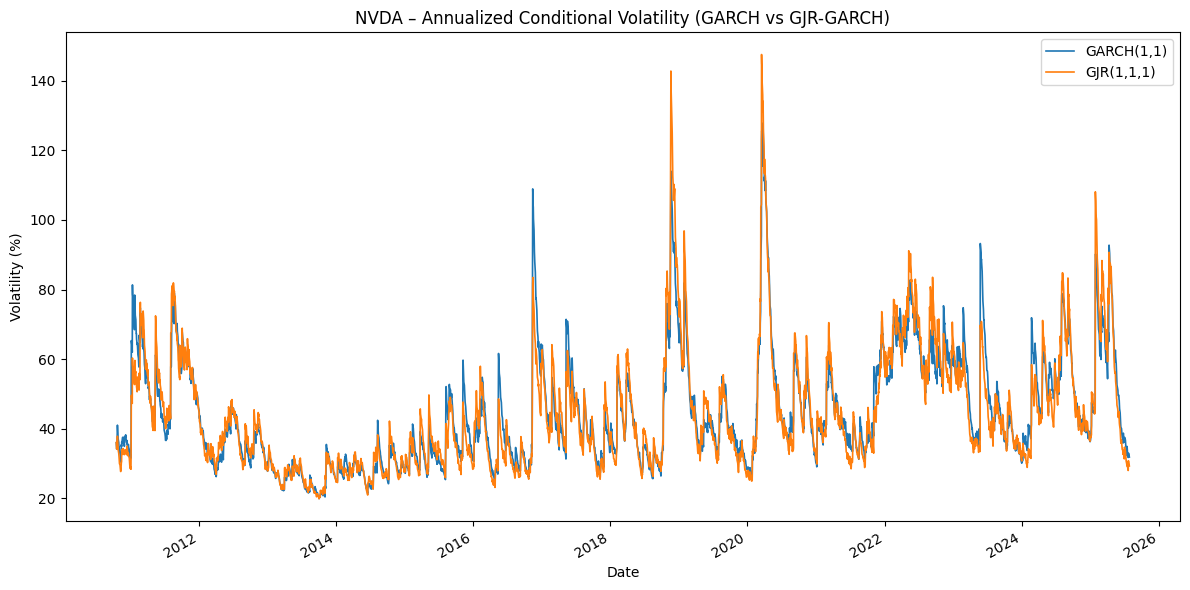

In [13]:
# --- 1) Returns from your df_feat['Close'] ---
px = df_feat['Close'].astype(float).dropna()
ret = 100 * np.log(px).diff().dropna()  # percent log-returns (common for arch)

# --- 2) Grid search by BIC for GARCH and GJR-GARCH ---
def select_by_bic(ret, max_p=5, max_q=5, max_o=1, gjr=False, dist="t"):
    best = {"bic": np.inf, "p": None, "o": 0, "q": None, "res": None}
    o_range = range(0, max_o + 1) if gjr else [0]  # o=0 => plain GARCH
    for p in range(0, max_p + 1):
        for q in range(1, max_q + 1):   # require some MA-in-variance
            for o in o_range:
                if p == 0 and q == 0 and o == 0:
                    continue
                try:
                    am = arch_model(ret, mean="Constant", vol="GARCH",
                                    p=p, o=o, q=q, dist=dist)
                    res = am.fit(disp="off")
                    if res.bic < best["bic"]:
                        best.update({"bic": res.bic, "p": p, "o": o, "q": q, "res": res})
                except Exception:
                    # skip non-convergent specs
                    pass
    return best

best_garch = select_by_bic(ret, max_p=5, max_q=5, max_o=0, gjr=False)
best_gjr   = select_by_bic(ret, max_p=5, max_q=5, max_o=2, gjr=True)

print(f"Best GARCH(p,q): (p,q)=({best_garch['p']},{best_garch['q']})  BIC={best_garch['bic']:.2f}")
print(f"Best GJR-GARCH(p,o,q): (p,o,q)=({best_gjr['p']},{best_gjr['o']},{best_gjr['q']})  BIC={best_gjr['bic']:.2f}")

# --- 3) (Re)fit chosen models on full sample (optional; we already have res objects) ---
res_garch = best_garch["res"]
res_gjr   = best_gjr["res"]

# --- 4) Collect conditional volatilities and annualize ---
vol_garch = res_garch.conditional_volatility.rename(
    f"GARCH({best_garch['p']},{best_garch['q']})"
)
vol_gjr = res_gjr.conditional_volatility.rename(
    f"GJR({best_gjr['p']},{best_gjr['o']},{best_gjr['q']})"
)

ann_factor = np.sqrt(252)  # daily data
ann_vol = pd.concat([vol_garch, vol_gjr], axis=1) * ann_factor

# --- 5) Plot ---
plt.figure(figsize=(12,6))
ann_vol.plot(ax=plt.gca(), lw=1.2)
plt.title("NVDA – Annualized Conditional Volatility (GARCH vs GJR-GARCH)")
plt.ylabel("Volatility (%)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


In [26]:
print("Correlation between GARCH and GJR-GARCH volatilities:")
print(np.corrcoef(vol_garch, vol_gjr)[0, 1]) 

Correlation between GARCH and GJR-GARCH volatilities:
0.9555778679235085


In [ ]:
# =========================
# Label Construction
# =========================
def make_labels(df_feat, label_mode="oc"):
    out = df_feat.copy()

    if label_mode == "oc":
        # Predict today's Open->Close direction using only info available by prior close
        # Label y_t = 1 if Close_t > Open_t, else 0
        out["y"] = (out["Close"] > out["Open"]).astype(int)
        # Strategy return for that day (simple return)
        out["ret_strategy_base"] = out["Close"] / out["Open"] - 1.0

        # To avoid leakage: shift features by 1 day so today's features are from prior day
        feature_cols = get_feature_cols(out)
        out[feature_cols] = out[feature_cols].shift(1)

    elif label_mode == "cc_adj":
        # Predict next day's AdjClose vs today's AdjClose
        out["y"] = (out["Close"].shift(-1) > out["Close"]).astype(int)
        # Strategy return measured close-to-close using Adjusted Close
        out["ret_strategy_base"] = out["Close"].shift(-1) / out["Close"] - 1.0

        # Features can use today's close safely; prediction acts for next day
        feature_cols = get_feature_cols(out)
        # no shift here

    else:
        raise ValueError("label_mode must be 'oc' or 'cc_adj'")

    out = out.dropna().copy()
    return out

def get_feature_cols(df_like):
    # All engineered features except raw price columns, label, base returns
    exclude = {"Open","High","Low","Close","Volume","y","ret_strategy_base"}
    return [c for c in df_like.columns if c not in exclude]

df_all = make_labels(df_feat, label_mode=LABEL_MODE)

In [ ]:
# =========================
# Train/Test Split
# =========================
def split_train_test_by_years(df, test_years=TEST_YEARS):
    last_dt = df.index.max()
    test_start = last_dt - relativedelta(years=test_years)
    train = df[df.index < test_start].copy()
    test  = df[df.index >= test_start].copy()
    return train, test, test_start

train, test, test_start = split_train_test_by_years(df_all, TEST_YEARS)
feature_cols = get_feature_cols(df_all)

X_train = train[feature_cols].values
y_train = train["y"].values
X_test  = test[feature_cols].values
y_test  = test["y"].values


### Def metrics report

In [ ]:
def cls_report(y_true, proba, y_pred):
    return {
        "AUC": roc_auc_score(y_true, proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "BalancedAcc": balanced_accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Brier": brier_score_loss(y_true, proba)
    }

## Random Forest model settings

In [52]:
def train_rf(X, y, n_splits=5, seed=SEED):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    rf = RandomForestClassifier(random_state=seed, class_weight="balanced", n_jobs=-1)
    param_dist = {
        "n_estimators": [200, 400, 600, 800],
        "max_depth": [None, 5, 8, 12, 16],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", None]
    }
    search = RandomizedSearchCV(
        rf, param_distributions=param_dist, n_iter=20,
        scoring="roc_auc", cv=tscv, random_state=seed, n_jobs=-1, verbose=0,
        return_train_score=True  # <-- needed for overfit control
    )
    search.fit(X, y)

    # CV train vs validation AUC for the best setting
    cv = pd.DataFrame(search.cv_results_)
    best_idx = search.best_index_
    rf_cv_summary = {
        "mean_train_auc": float(cv.loc[best_idx, "mean_train_score"]),
        "mean_cv_auc": float(cv.loc[best_idx, "mean_test_score"]),
        "gap_auc": float(cv.loc[best_idx, "mean_train_score"] - cv.loc[best_idx, "mean_test_score"])
    }
    return search.best_estimator_, search.best_params_, rf_cv_summary


In [53]:
rf_model, rf_params, rf_cv = train_rf(X_train, y_train)
rf_proba_test = rf_model.predict_proba(X_test)[:, 1]
rf_pred_test  = (rf_proba_test >= 0.5).astype(int)
rf_metrics = cls_report(y_test, rf_proba_test, rf_pred_test)

# (optional) Apparent train metric for reference (optimistic by nature)
rf_proba_train_app = rf_model.predict_proba(X_train)[:, 1]
rf_metrics_train_app = cls_report(y_train, rf_proba_train_app, (rf_proba_train_app >= 0.5).astype(int))


## LSTM model settings

In [ ]:
# =========================
# 6) LSTM (PyTorch version)
# =========================
def make_sequences(X, y, index, seq_len=60):
    Xs, ys, idxs = [], [], []
    for i in range(seq_len, len(X)):
        Xs.append(X[i-seq_len:i])
        ys.append(y[i])
        idxs.append(index[i])
    return np.array(Xs), np.array(ys), np.array(idxs)

# Scale (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Sliding windows
Xtr_seq, ytr_seq, idx_tr = make_sequences(X_train_scaled, y_train, train.index.values, SEQ_LEN)
Xte_seq, yte_seq, idx_te = make_sequences(X_test_scaled,  y_test,  test.index.values,  SEQ_LEN)

# Time-based train/val split
val_frac = 0.2
cut = int((1 - val_frac) * len(Xtr_seq))
Xtr, ytr = Xtr_seq[:cut], ytr_seq[:cut]
Xval, yval = Xtr_seq[cut:], ytr_seq[cut:]

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class LSTMClassifier(nn.Module):
    def __init__(self, n_features, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=hidden1, batch_first=True)
        self.drop1  = nn.Dropout(dropout)
        self.lstm2 = nn.LSTM(input_size=hidden1, hidden_size=hidden2, batch_first=True)
        self.drop2  = nn.Dropout(dropout)
        self.fc     = nn.Linear(hidden2, 1)
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.drop1(x)
        x, _ = self.lstm2(x)
        x = self.drop2(x[:, -1, :])      # last time step
        logit = self.fc(x).squeeze(-1)
        return logit


In [54]:
def train_lstm_pytorch(Xtr, ytr, Xval, yval, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=1e-3, patience=5):
    train_ds = SeqDataset(Xtr, ytr);   val_ds = SeqDataset(Xval, yval)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  drop_last=False)
    # eval loaders (no shuffle)
    train_eval_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=False, drop_last=False)
    val_dl   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    model = LSTMClassifier(n_features=Xtr.shape[-1]).to(DEVICE)

    pos = float(ytr.sum()); neg = float(len(ytr) - ytr.sum())
    pos_weight_val = (neg / pos) if pos > 0 else 1.0
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight_val, dtype=torch.float32, device=DEVICE))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_auc = -np.inf
    patience_left = patience
    best_state = None

    hist = {"train_auc": [], "val_auc": [], "train_loss": [], "val_loss": []}

    for epoch in range(1, epochs+1):
        # ---- Train
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # ---- Evaluate train
        model.eval()
        tr_probs, tr_targets, tr_losses = [], [], []
        with torch.no_grad():
            for xb, yb in train_eval_dl:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                logits = model(xb)
                probs = torch.sigmoid(logits)
                loss = criterion(logits, yb)
                tr_probs.append(probs.cpu().numpy())
                tr_targets.append(yb.cpu().numpy())
                tr_losses.append(loss.item())
        tr_probs = np.concatenate(tr_probs); tr_targets = np.concatenate(tr_targets)
        train_auc = roc_auc_score(tr_targets, tr_probs)
        train_loss = float(np.mean(tr_losses))

        # ---- Evaluate val
        val_probs, val_targets, val_losses = [], [], []
        with torch.no_grad():
            for xb, yb in val_dl:
                xb = xb.to(DEVICE); yb = yb.to(DEVICE)
                logits = model(xb)
                probs = torch.sigmoid(logits)
                loss = criterion(logits, yb)
                val_probs.append(probs.cpu().numpy())
                val_targets.append(yb.cpu().numpy())
                val_losses.append(loss.item())
        val_probs = np.concatenate(val_probs); val_targets = np.concatenate(val_targets)
        val_auc = roc_auc_score(val_targets, val_probs)
        val_loss = float(np.mean(val_losses))

        hist["train_auc"].append(train_auc); hist["val_auc"].append(val_auc)
        hist["train_loss"].append(train_loss); hist["val_loss"].append(val_loss)

        # Early stopping on val AUC
        if val_auc > best_auc:
            best_auc = val_auc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience_left = patience
        else:
            patience_left -= 1
            if patience_left <= 0:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    model.to(DEVICE)
    return model, best_auc, hist


In [55]:
lstm_model, best_val_auc, lstm_hist = train_lstm_pytorch(Xtr, ytr, Xval, yval, epochs=EPOCHS, batch_size=BATCH_SIZE)

# Test predictions unchanged
test_ds = SeqDataset(Xte_seq, yte_seq)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
lstm_proba_seq = []
with torch.no_grad():
    lstm_model.eval()
    for xb, _ in test_dl:
        xb = xb.to(DEVICE)
        logits = lstm_model(xb)
        probs = torch.sigmoid(logits).cpu().numpy()
        lstm_proba_seq.append(probs)
lstm_proba_seq = np.concatenate(lstm_proba_seq).ravel()
lstm_pred_seq  = (lstm_proba_seq >= 0.5).astype(int)
y_test_seq_aligned = yte_seq
test_idx_seq = pd.to_datetime(idx_te)
lstm_metrics = cls_report(y_test_seq_aligned, lstm_proba_seq, lstm_pred_seq)

# LSTM train/val AUC at the "best val" epoch
best_epoch = int(np.argmax(lstm_hist["val_auc"]))
lstm_train_auc_best = float(lstm_hist["train_auc"][best_epoch])
lstm_val_auc_best   = float(lstm_hist["val_auc"][best_epoch])
lstm_gap_auc        = lstm_train_auc_best - lstm_val_auc_best


## Prove overfitting


=== Overfitting / Underfitting Control ===

[Random Forest]
  CV mean TRAIN AUC (best): 0.8932
  CV mean VALID AUC (best): 0.5049
  Generalization Gap (AUC): 0.3883
  OOS TEST AUC:            0.5301
  Flag: Leaning Overfit

[LSTM]
  TRAIN AUC @ best VAL ep: 0.5704
  VALID AUC @ best VAL ep: 0.5150
  Generalization Gap (AUC): 0.0554
  OOS TEST AUC:             0.5488
  Flag: Leaning Overfit


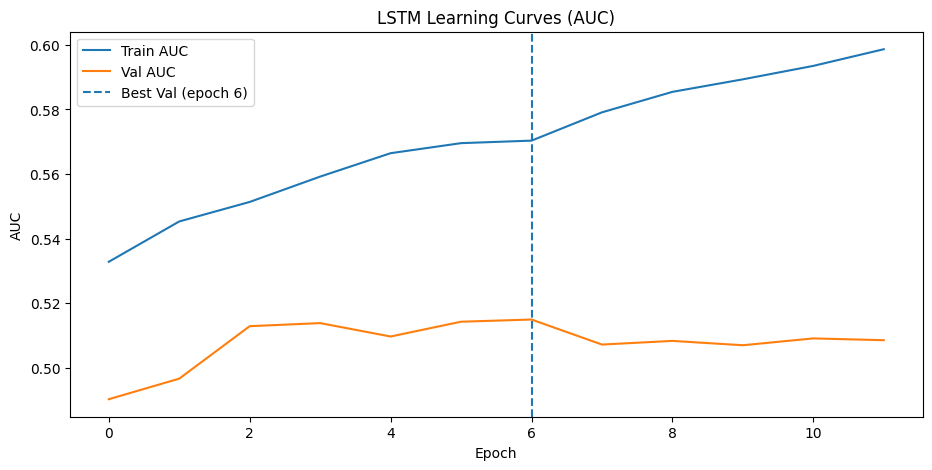

In [56]:
def assess_overfit(train_auc, val_auc, test_auc=None, gap_thresh=0.05, low_thresh=0.53):
    """
    Simple rule-based flag:
      - Underfit: val (and test) AUC near chance
      - Overfit: large train-val gap and val>>test drop
      - Leaning Overfit: large train-val gap but test close to val
      - OK: otherwise
    """
    gap = train_auc - val_auc
    flag = "OK"
    if val_auc < low_thresh and (test_auc is None or test_auc < low_thresh):
        flag = "Underfit"
    elif gap > gap_thresh and (test_auc is not None) and (val_auc - test_auc) > 0.02:
        flag = "Overfit"
    elif gap > gap_thresh:
        flag = "Leaning Overfit"
    return {"gap_auc": float(gap), "flag": flag}

# Assess RF (train vs CV; and OOS test AUC)
rf_assess = assess_overfit(
    train_auc=rf_cv["mean_train_auc"],
    val_auc=rf_cv["mean_cv_auc"],
    test_auc=rf_metrics["AUC"]
)

# Assess LSTM (train vs val at best epoch; and OOS test AUC)
lstm_assess = assess_overfit(
    train_auc=lstm_train_auc_best,
    val_auc=lstm_val_auc_best,
    test_auc=lstm_metrics["AUC"]
)

print("\n=== Overfitting / Underfitting Control ===")
print("\n[Random Forest]")
print(f"  CV mean TRAIN AUC (best): {rf_cv['mean_train_auc']:.4f}")
print(f"  CV mean VALID AUC (best): {rf_cv['mean_cv_auc']:.4f}")
print(f"  Generalization Gap (AUC): {rf_assess['gap_auc']:.4f}")
print(f"  OOS TEST AUC:            {rf_metrics['AUC']:.4f}")
print(f"  Flag: {rf_assess['flag']}")

print("\n[LSTM]")
print(f"  TRAIN AUC @ best VAL ep: {lstm_train_auc_best:.4f}")
print(f"  VALID AUC @ best VAL ep: {lstm_val_auc_best:.4f}")
print(f"  Generalization Gap (AUC): {lstm_gap_auc:.4f}")
print(f"  OOS TEST AUC:             {lstm_metrics['AUC']:.4f}")
print(f"  Flag: {lstm_assess['flag']}")

# Optional: plot LSTM train vs val AUC across epochs
plt.figure()
plt.plot(lstm_hist["train_auc"], label="Train AUC")
plt.plot(lstm_hist["val_auc"],   label="Val AUC")
plt.axvline(best_epoch, linestyle="--", label=f"Best Val (epoch {best_epoch})")
plt.title("LSTM Learning Curves (AUC)")
plt.xlabel("Epoch"); plt.ylabel("AUC"); plt.legend()
plt.show()


In [57]:
# =========================
# 7) Choose "best" model by a metric and Backtest
# =========================
def pick_best_model(rf_metrics, lstm_metrics, primary="BalancedAcc", secondary="AUC"):
    # Return string "rf" or "lstm"
    def tup(m): return (m[primary], m[secondary])
    return "rf" if tup(rf_metrics) >= tup(lstm_metrics) else "lstm"

chosen = pick_best_model(rf_metrics, lstm_metrics, primary="BalancedAcc", secondary="AUC")

# Prepare a probability series on the test set for the chosen model
if chosen == "rf":
    proba_series = pd.Series(rf_proba_test, index=test.index)
    # Drop first SEQ_LEN days from test to intersect with LSTM index later (optional)
else:
    proba_series = pd.Series(lstm_proba_seq, index=test_idx_seq)

# For backtest, we also need the base return for each day (aligned index)
ret_base = df_all.loc[proba_series.index, "ret_strategy_base"].copy()
y_true_bt = df_all.loc[proba_series.index, "y"].copy()

## Backtest strategy

In [58]:
# =========================
# 8) Backtest Engine
# =========================
def backtest_from_proba(proba: pd.Series,
                        ret_base: pd.Series,
                        upper=0.55, lower=0.45,
                        tc_bps=10):
    """Position: +1 if proba>=upper; -1 if proba<=lower; 0 otherwise.
       Strategy return_t = pos_t * ret_base_t - tc * |pos_t - pos_{t-1}|.
       tc_bps is one-way cost in basis points (e.g., 10bps = 0.0010)."""
    proba = proba.dropna()
    ret_base = ret_base.reindex(proba.index).dropna()
    # Align
    idx = proba.index.intersection(ret_base.index)
    p = proba.loc[idx]
    r = ret_base.loc[idx]

    pos = pd.Series(0, index=idx, dtype=float)
    pos[p >= upper] = 1.0
    pos[p <= lower] = -1.0
    pos = pos.ffill().fillna(0.0)  # hold last position until new signal; comment this if you want daily re-evaluation only

    # Transaction costs on position change
    tc = (tc_bps / 10000.0) * pos.diff().abs().fillna(0.0)

    strat_ret = pos * r - tc
    bh_ret = r.copy()  # buy-and-hold intraday (if LABEL_MODE=='oc') or cc_adj (if 'cc_adj')

    out = pd.DataFrame({
        "proba": p,
        "pos": pos,
        "ret": strat_ret,
        "bh": bh_ret,
        "y_true": y_true_bt.reindex(idx)
    })
    out["eq"] = (1 + out["ret"]).cumprod()
    out["bh_eq"] = (1 + out["bh"]).cumprod()

    return out

bt = backtest_from_proba(proba_series, ret_base, upper=UPPER, lower=LOWER, tc_bps=TC_BPS)


<Axes: title={'center': 'LSTM Backtest Strategy Returns'}>

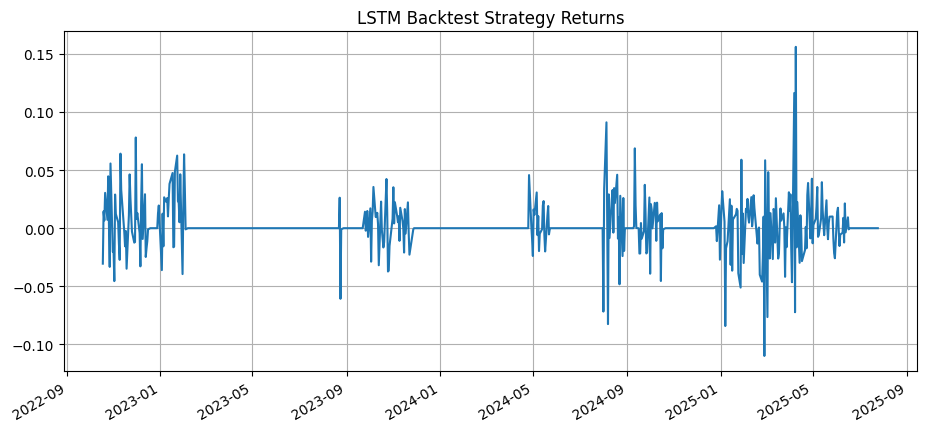

In [62]:
bt["ret"].plot(title=f"{chosen.upper()} Backtest Strategy Returns", grid=True, figsize=(11, 5))

In [59]:
# =========================
# 9) Backtest Metrics & Plots
# =========================
def performance_stats(returns: pd.Series, freq=252):
    mu = returns.mean() * freq
    sd = returns.std(ddof=1) * np.sqrt(freq)
    sharpe = mu / sd if sd > 0 else np.nan

    # Max drawdown
    eq = (1 + returns).cumprod()
    peak = eq.cummax()
    dd = (eq / peak - 1.0)
    max_dd = dd.min()

    # CAGR (assumes daily freq)
    total_ret = eq.iloc[-1] - 1.0
    n_years = len(eq) / freq
    cagr = (eq.iloc[-1])**(1/n_years) - 1 if n_years > 0 else np.nan

    win_rate = (returns > 0).mean()

    return {
        "CAGR": cagr,
        "Sharpe": sharpe,
        "MaxDD": max_dd,
        "WinRate": win_rate,
        "AvgDailyRet": returns.mean(),
        "DailyVol": returns.std(ddof=1)
    }

## Results

=== RANDOM FOREST test metrics ===
         AUC: 0.5301
    Accuracy: 0.4695
 BalancedAcc: 0.5016
   Precision: 0.5517
      Recall: 0.1553
          F1: 0.2424
       Brier: 0.2554

=== LSTM test metrics ===
         AUC: 0.5488
    Accuracy: 0.5533
 BalancedAcc: 0.5157
   Precision: 0.5547
      Recall: 0.9235
          F1: 0.6931
       Brier: 0.2462

Chosen model: LSTM

=== Backtest (chosen model) ===
        CAGR: 0.4580
      Sharpe: 1.3828
       MaxDD: -0.2649
     WinRate: 0.2507
 AvgDailyRet: 0.0017
    DailyVol: 0.0193

=== Buy & Hold (same horizon) ===
        CAGR: 0.3969
      Sharpe: 1.0171
       MaxDD: -0.4191
     WinRate: 0.5461
 AvgDailyRet: 0.0017
    DailyVol: 0.0260

=== Classification (backtest window, p>=0.5) ===
         AUC: 0.5488
    Accuracy: 0.5533
 BalancedAcc: 0.5157
   Precision: 0.5547
      Recall: 0.9235
          F1: 0.6931
       Brier: 0.2462


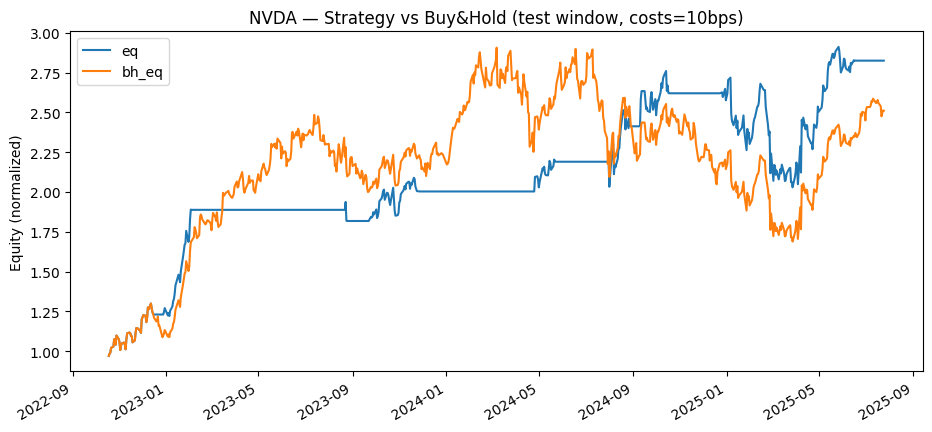

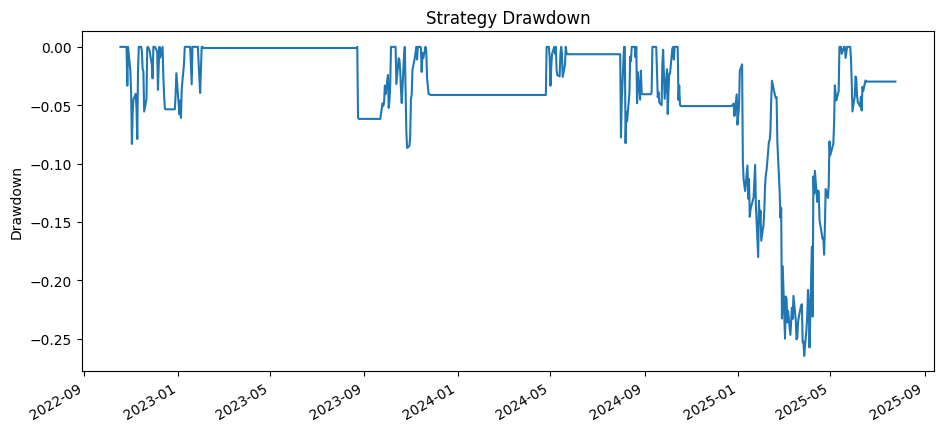

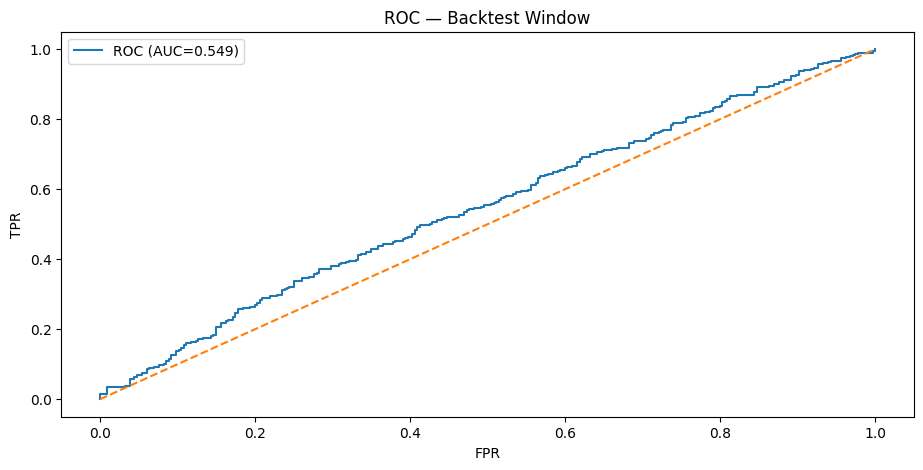

In [60]:
perf = performance_stats(bt["ret"])
perf_bh = performance_stats(bt["bh"])

# Classification quality on the backtest window (threshold 0.5 for reference)
y_bt = bt["y_true"].astype(int)
y_hat_bt = (bt["proba"] >= 0.5).astype(int)
bt_cls = cls_report(y_bt, bt["proba"], y_hat_bt)

print("=== RANDOM FOREST test metrics ===")
for k,v in rf_metrics.items():
    print(f"{k:>12}: {v:.4f}")
print("\n=== LSTM test metrics ===")
for k,v in lstm_metrics.items():
    print(f"{k:>12}: {v:.4f}")

print(f"\nChosen model: {chosen.upper()}")

print("\n=== Backtest (chosen model) ===")
for k,v in perf.items():
    print(f"{k:>12}: {v:.4f}")
print("\n=== Buy & Hold (same horizon) ===")
for k,v in perf_bh.items():
    print(f"{k:>12}: {v:.4f}")

print("\n=== Classification (backtest window, p>=0.5) ===")
for k,v in bt_cls.items():
    print(f"{k:>12}: {v:.4f}")

# Plots
ax = bt[["eq","bh_eq"]].plot(title=f"{TICKER} — Strategy vs Buy&Hold (test window, costs={TC_BPS}bps)")
ax.set_ylabel("Equity (normalized)")
plt.show()

# Drawdown
eq = bt["eq"]
dd = eq/eq.cummax() - 1
dd.plot(title="Strategy Drawdown")
plt.ylabel("Drawdown")
plt.show()

# ROC curve for chosen model (backtest window)
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_bt, bt["proba"])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC — Backtest Window")
plt.legend()
plt.show()